In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from utils import clear_data, encode_data, conf_matrix, evaluate_metrics, add_sessions

warnings.filterwarnings('ignore')

## Data preparation

In [2]:
data = pd.read_csv("data/train_users_processed.csv")
test_data = pd.read_csv("data/test_users.csv")

In [3]:
sessions = pd.read_csv("data/sessions_processed.csv")
sessions = sessions.rename(columns={"user_id": "id"})

In [4]:
data_sessions = add_sessions(data, sessions)
data_sessions

,id,date_account_created,timestamp_first_active,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,...,booking_request,booking_response,click,data,message_post,modify,partner_callback,submit,view,hours_elapsed_sum
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,-unknown-,37.0,facebook,0,en,direct,direct,...,0.0,0.0,11.0,13.0,0.0,0.0,0.0,3.0,16.0,322.00
1,efpisjs1kq,2010-06-16,2010-06-16 18:38:28,-unknown-,37.0,facebook,2,en,other,craigslist,...,0.0,0.0,11.0,13.0,0.0,0.0,0.0,3.0,16.0,322.00
2,vtrminb4wp,2010-06-19,2010-06-19 18:21:58,-unknown-,37.0,facebook,2,en,other,craigslist,...,0.0,0.0,11.0,13.0,0.0,0.0,0.0,3.0,16.0,322.00
3,9432okxsz3,2010-06-23,2010-06-23 21:37:11,-unknown-,35.0,facebook,2,en,other,craigslist,...,0.0,0.0,11.0,13.0,0.0,0.0,0.0,3.0,16.0,322.00
4,02n2968rji,2010-06-28,2010-06-28 21:26:46,-unknown-,37.0,facebook,2,en,other,craigslist,...,0.0,0.0,11.0,13.0,0.0,0.0,0.0,3.0,16.0,322.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205060,ttcvetavqt,2014-06-11,2014-06-11 23:08:23,OTHER,29.0,facebook,25,en,direct,direct,...,0.0,0.0,1.0,16.0,3.0,0.0,0.0,6.0,23.0,426.84
205061,51cjjsxd12,2014-01-09,2014-01-09 21:56:33,OTHER,37.0,facebook,0,en,seo,google,...,0.0,0.0,9.0,23.0,0.0,0.0,0.0,1.0,21.0,548.55
205062,eq5zrmfl7a,2012-12-29,2012-12-29 19:39:41,OTHER,40.0,facebook,0,en,direct,direct,...,0.0,0.0,19.0,29.0,2.0,0.0,0.0,5.0,39.0,512.00
205063,g5nzu22ygx,2014-06-20,2014-06-20 04:32:42,OTHER,25.0,facebook,0,en,direct,direct,...,1.0,0.0,7.0,8.0,1.0,0.0,0.0,4.0,57.0,1192.18


In [5]:
df = encode_data(data_sessions)
cat_type = CategoricalDtype(df["country_destination"].unique(), ordered=True)
df["country_destination"] = df["country_destination"].astype(cat_type).cat.codes

In [6]:
cleared_test_data = clear_data(test_data)
cleared_test_data_sessions = add_sessions(cleared_test_data, sessions)
test_df = encode_data(cleared_test_data_sessions)

In [7]:
X = df.drop(["country_destination"], axis=1)
y = df["country_destination"]

cols_not_in_test = set(X).difference(set(test_df.columns))
cols_not_in_X = set(test_df).difference(set(X.columns))

# dealing with missing unique values in both dataframes

for col in cols_not_in_test:
    test_df[col] = 0
    
for col in cols_not_in_X:
    X[col] = 0
    
test_df.columns = X.columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)  #for conf matrix computation


# computes metrics (using CV with 5 folds) and prints confusion matrix for separate part of data
def show_perfomance(estimator, X, X_train_xx, y, y_train_xx):
    evaluate_metrics(estimator, X, y)
    
    estimator.fit(X_train_xx, y_train_xx)
    y_pred = estimator.predict(X_test)
    conf_matrix(y_test, y_pred)

### Base tree model training

Accuracy: 0.655753053909736
Precision: 0.2887515064641395
Recall: 0.16526262024833757
F1: 0.18307501592249315


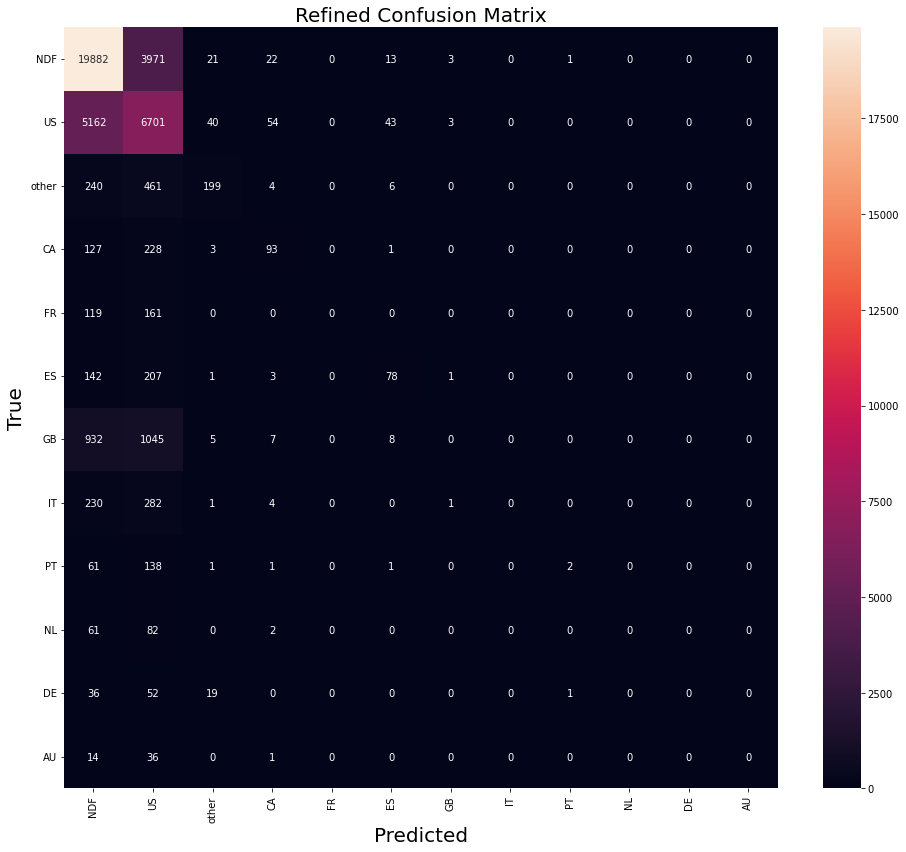

In [8]:
tree = DecisionTreeClassifier(max_depth=8, criterion="entropy")
show_perfomance(tree, X, X_train, y, y_train)

In [9]:
weights = {0: 1,
           1: 1,
           2: 1,
           4: 1,
           7: 1,
           6: 1,
           5: 1,
           3: 1,
           10: 1,
           9: 1,
           11: 1,
           8: 1}

Accuracy: 0.6554019457245264
Precision: 0.2846066410013216
Recall: 0.16483218370490627
F1: 0.18222791195199914


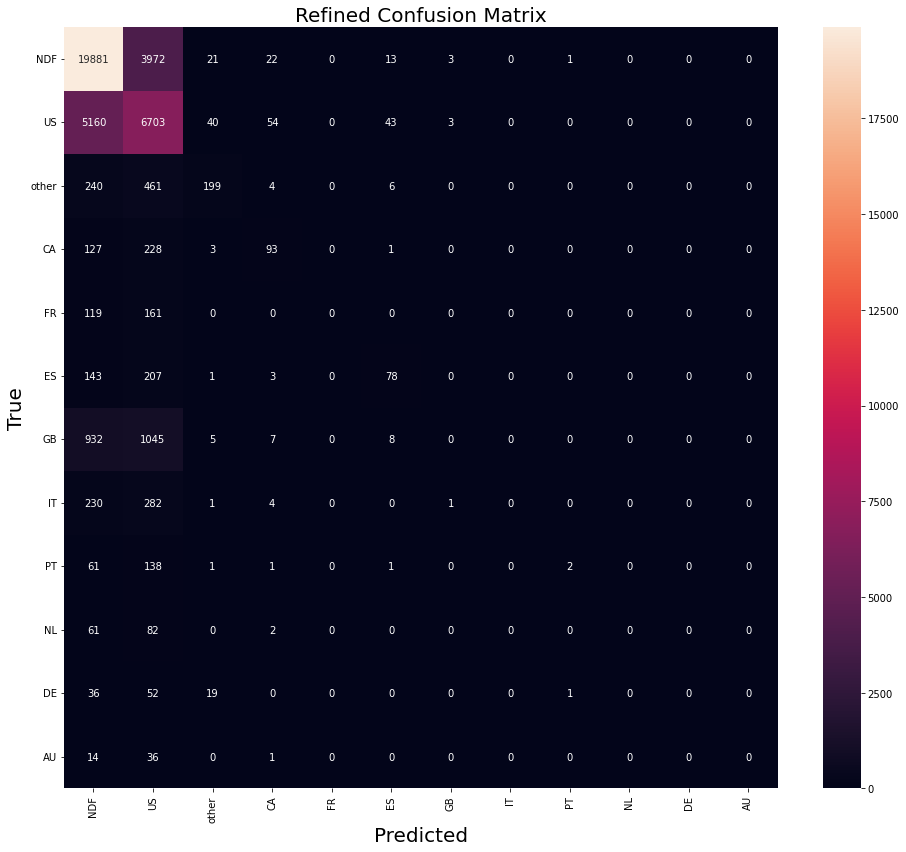

In [10]:
tree_weigths = DecisionTreeClassifier(max_depth=8, criterion="entropy", class_weight=weights)
show_perfomance(tree_weigths, X, X_train, y, y_train)

### Tree model with random oversampling

In [11]:
strategy_over = {3: 15000,
                 4: 15000,
                 5: 15000,
                 6: 15000,
                 7: 15000,
                 8: 15000,
                 9: 15000,
                 10: 15000,
                 11: 15000}

ros = RandomOverSampler(sampling_strategy=strategy_over)
X_os, y_os = ros.fit_resample(X, y)
X_train_os, y_train_os = ros.fit_resample(X_train, y_train)

Accuracy: 0.4616584796591017
Precision: 0.5227261352691744
Recall: 0.20892581445758623
F1: 0.22921627930203545


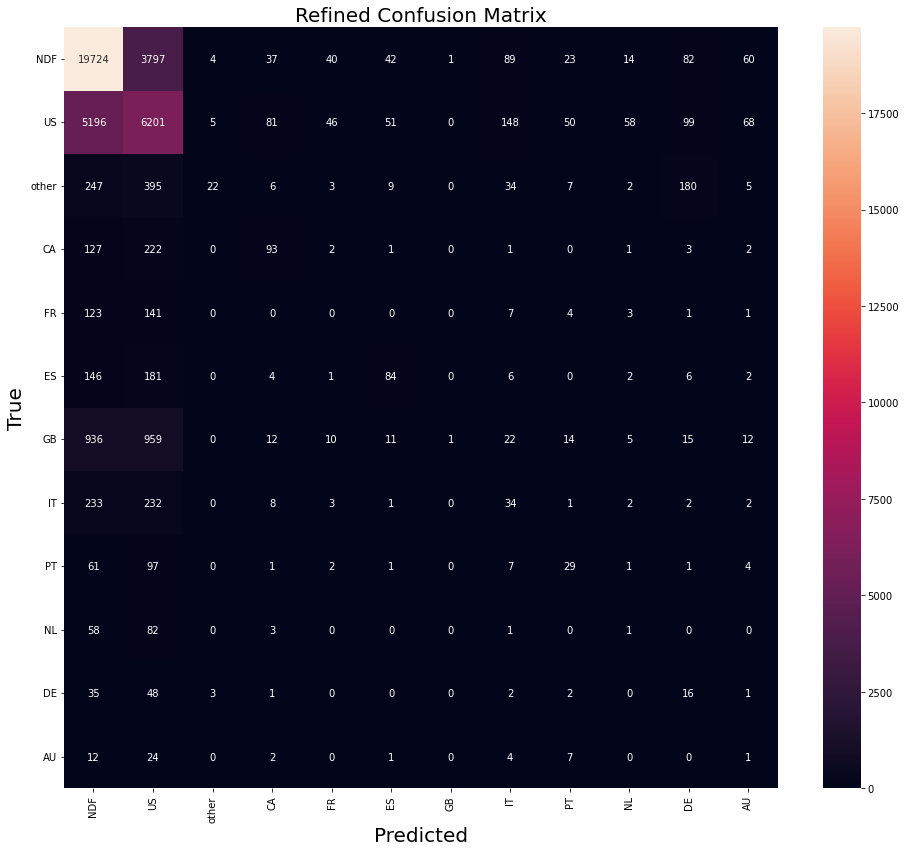

In [12]:
tree_os = DecisionTreeClassifier(max_depth=8, criterion="entropy")

show_perfomance(tree_os, X_os, X_train_os, y_os, y_train_os)

del X_os, y_os, X_train_os, y_train_os, tree_os

### Tree model with undersampling

In [13]:
strategy_under = {0: 60000,
                  1: 30000}

rus = RandomUnderSampler(sampling_strategy=strategy_under)
X_us, y_us = rus.fit_resample(X, y)
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

Accuracy: 0.5901839120121486
Precision: 0.32111605471239096
Recall: 0.17747934431228474
F1: 0.19792602821434993


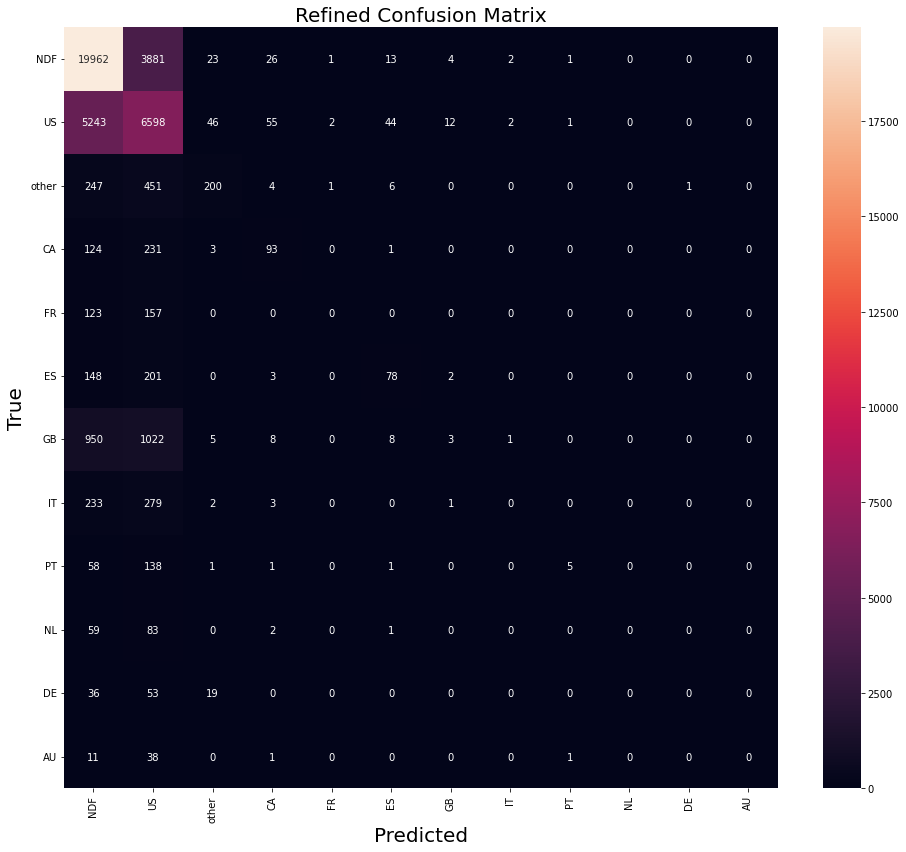

In [14]:
tree_us = DecisionTreeClassifier(max_depth=8, criterion="entropy")

show_perfomance(tree_us, X_us, X_train_us, y_us, y_train_us)

del X_us, y_us, X_train_us, y_train_us, tree_us

### Tree model with oversampling using SMOTE

In [ ]:
strategy_smote = {3: 25000,
                  4: 25000,
                  5: 25000,
                  6: 25000,
                  7: 25000,
                  8: 25000,
                  9: 25000,
                  10: 25000,
                  11: 25000}

smote = SMOTENC(categorical_features=list(range(1, len(X.columns))),sampling_strategy=strategy_smote)
X_sm, y_sm = smote.fit_resample(X, y)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

Accuracy: 0.37481107064430047
Precision: 0.40298725299096894
Recall: 0.19950385737952755
F1: 0.19978764290266177


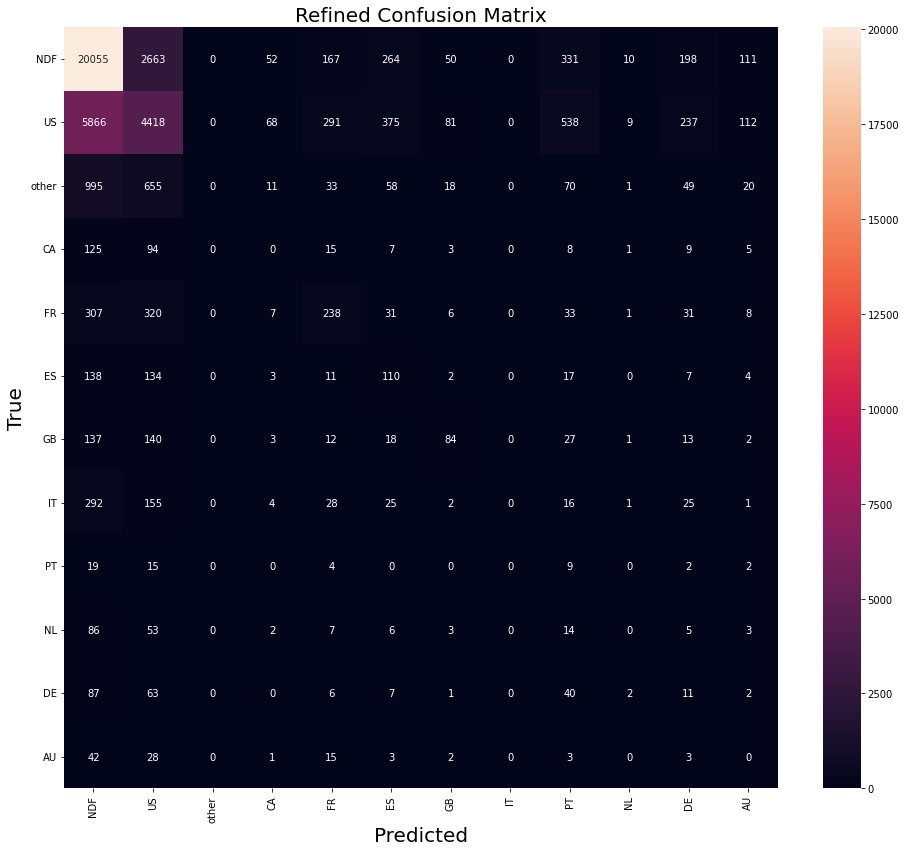

In [14]:
tree_sm = DecisionTreeClassifier(max_depth=8, criterion="entropy")

show_perfomance(tree_sm, X_sm, X_train_sm, y_sm, y_train_sm)

del X_sm, y_sm, X_train_sm, y_train_sm, tree_sm

### Tree model with undersampling using NearMiss

In [15]:
strategy_nearmiss = {0: 50000,
                     1: 30000}

nm = NearMiss(sampling_strategy=strategy_nearmiss)
X_nm, y_nm = nm.fit_resample(X, y)
X_train_nm, y_train_nm = nm.fit_resample(X_train, y_train)

Accuracy: 0.6151284085420382
Precision: 0.3542329561699702
Recall: 0.2136293182708319
F1: 0.23213560930009675


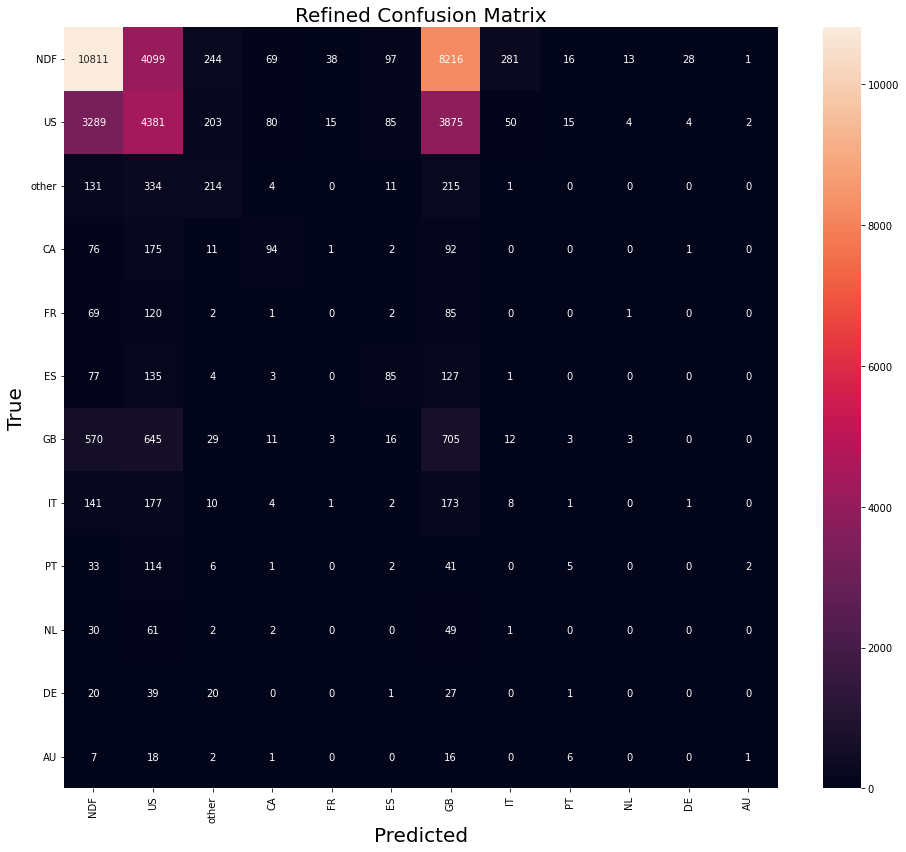

In [16]:
tree_nm = DecisionTreeClassifier(max_depth=8, criterion="entropy")

show_perfomance(tree_nm, X_nm, X_train_nm, y_nm, y_train_nm)

del X_nm, y_nm, X_train_nm, y_train_nm, tree_nm

### Tree OnevsRest model training

Accuracy: 0.655094726062468
Precision: 0.29507846998457155
Recall: 0.15397664788981494
F1: 0.16754790211082762


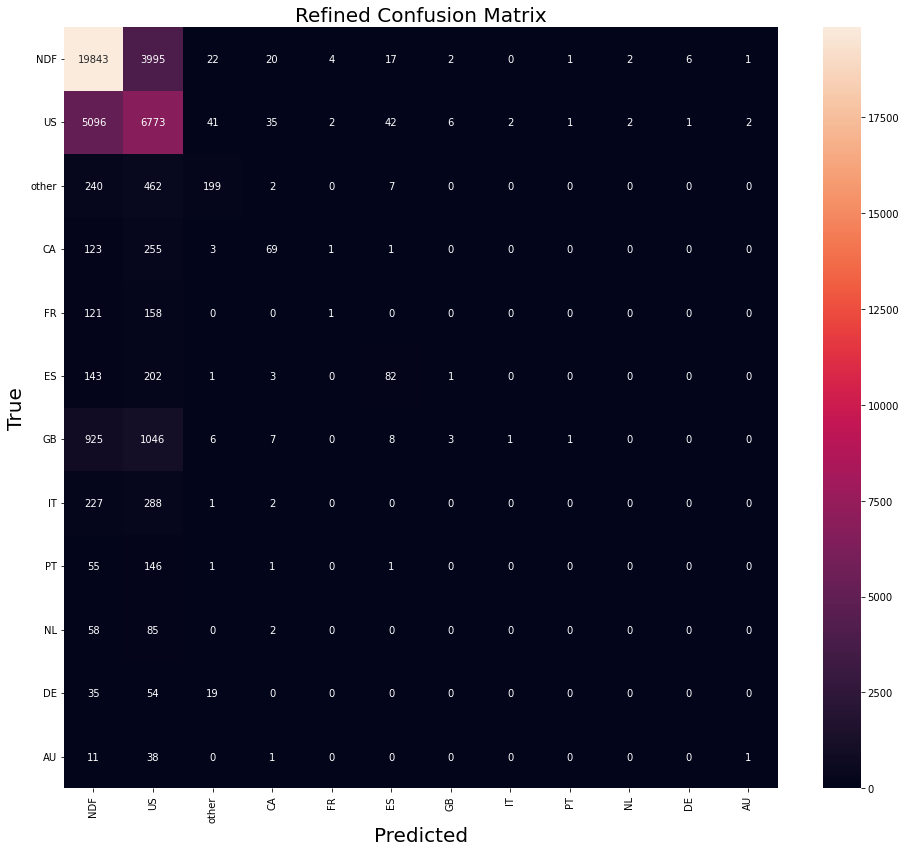

In [17]:
tree_ovr = OneVsRestClassifier(DecisionTreeClassifier(max_depth=7, criterion="entropy"))

show_perfomance(tree_ovr, X, X_train, y, y_train)

del tree_ovr

### Random forest model training

In [18]:
from sklearn.ensemble import RandomForestClassifier

Accuracy: 0.6562407041669716
Precision: 0.3325829377748709
Recall: 0.14392153419858822
F1: 0.15490621661265058


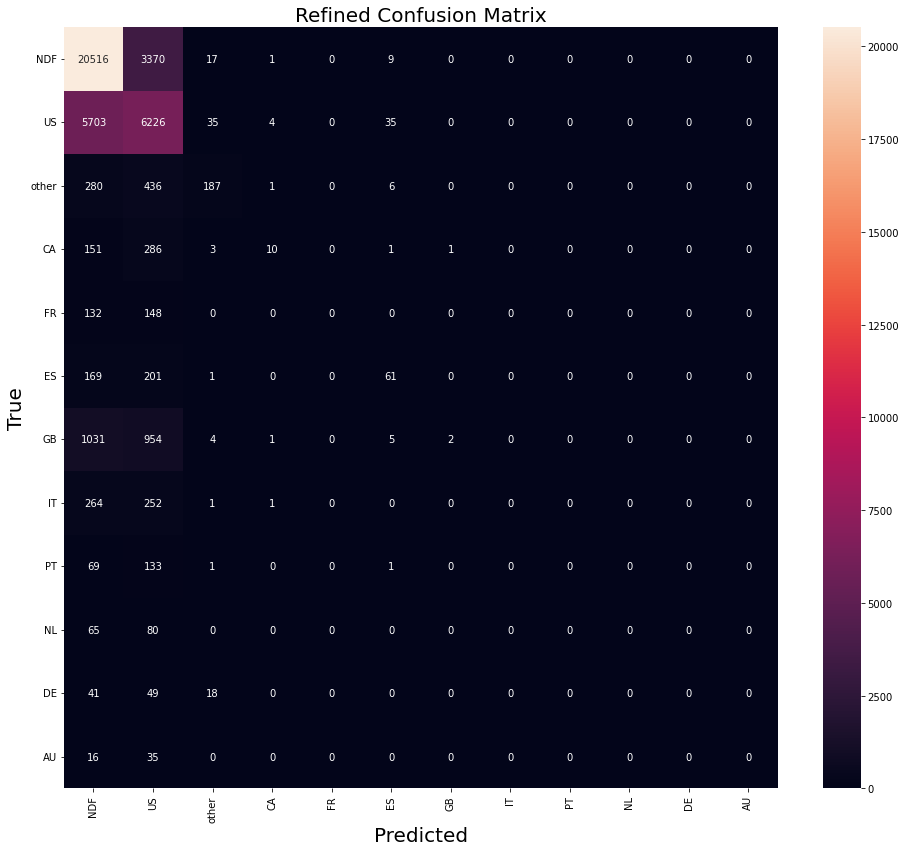

In [19]:
forest = RandomForestClassifier(n_estimators=100, max_depth=15, criterion="entropy")

show_perfomance(forest, X, X_train, y, y_train)

del forest

### XGBoost model training

In [20]:
from xgboost import XGBClassifier

Accuracy: 0.6578255675029869
Precision: 0.3262227286414371
Recall: 0.16638117061234675
F1: 0.18710498400618494


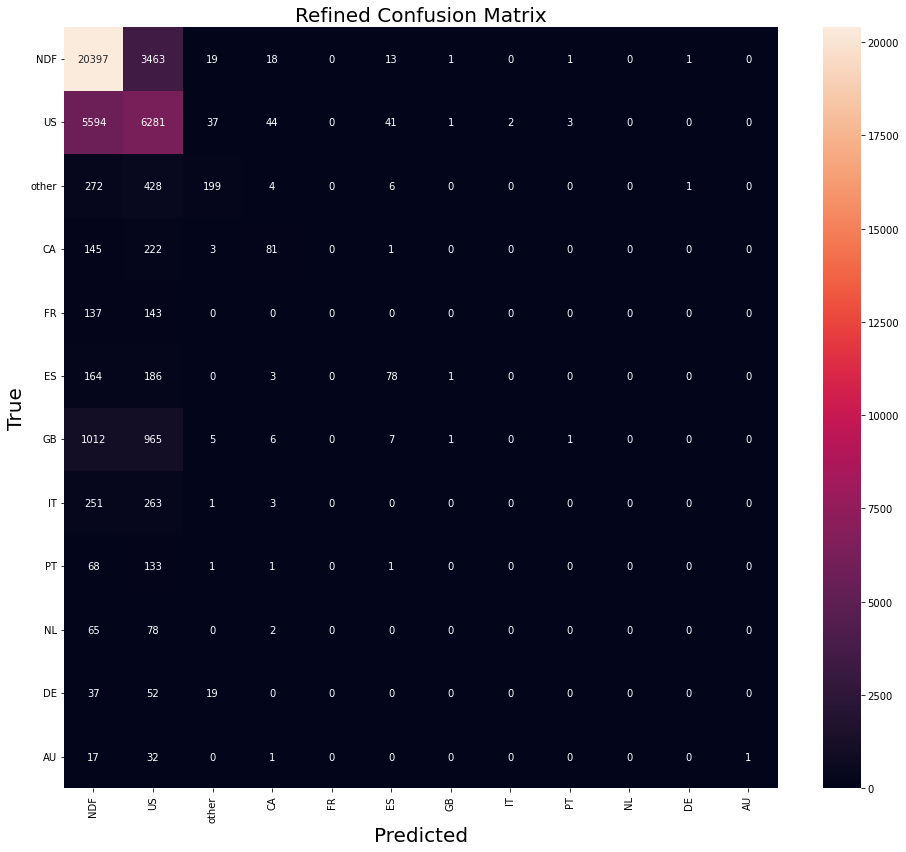

In [21]:
xgb_model = XGBClassifier(n_estimators=30, max_depth=6)

show_perfomance(xgb_model, X, X_train, y, y_train)

del xgb_model

### KNN model training

In [22]:
from sklearn.neighbors import KNeighborsClassifier

Accuracy: 0.5571843074147221
Precision: 0.1249058765933708
Recall: 0.09464895721091268
F1: 0.08878586967035632


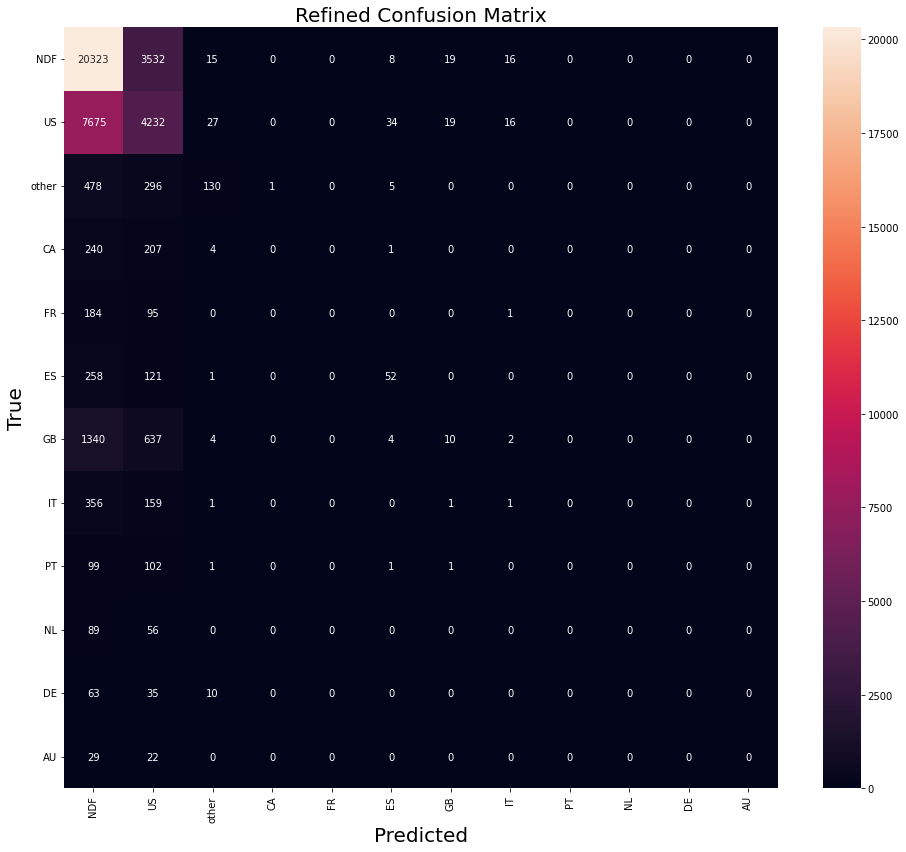

In [23]:
KNN = KNeighborsClassifier(n_neighbors=7)

show_perfomance(KNN, X, X_train, y, y_train)

del KNN

### Run model on test data

In [31]:
y_test_pred = tree.predict(test_df)
y_test_pred = pd.Series(y_test_pred)
categories = cat_type.categories

y_test_pred = y_test_pred.apply(lambda x: categories[x])

In [32]:
submission = pd.DataFrame({"id": test_data["id"], "country": y_test_pred})

In [33]:
submission.to_csv("submissions/submission_0.csv")